# Author: Стурейко Игорь
## Project: Geekbrains.Algorithms
## Lesson 04 - Дерево решений
## Date: 2020-09-03

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

## ООП Реализация

In [2]:
class Node:
    INSTANCE=0
    
    def __init__(self, x, y, idxs, min_leaf=5, max_nodes=100, criteria='gini'):
        self.x = x 
        self.y = y
        self.idxs = idxs 
        self.min_leaf = min_leaf
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.max_nodes = max_nodes
        self.criteria = criteria
        self.find_varsplit()
        
    def find_varsplit(self):
        for c in range(self.col_count): 
            self.find_better_split(c)

        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        
        self.lhs = Node(self.x, self.y, self.idxs[lhs], self.min_leaf, max_nodes=self.max_nodes, criteria=self.criteria)
        self.rhs = Node(self.x, self.y, self.idxs[rhs], self.min_leaf, max_nodes=self.max_nodes, criteria=self.criteria)
        
    def find_better_split(self, var_idx):
        """
        Нахлждение лучшего разбиения
        """
        x = self.x[self.idxs, var_idx]
        
        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]
            if rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf: continue

            curr_score = self.find_score(lhs, rhs, self.criteria)
            if curr_score < self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]
                
    def find_score(self, lhs, rhs, criteria):
        """
        Оценка информативности разбиения
        """
        y = self.y[self.idxs]
        
        p = float(y[lhs].shape[0]) / (y[lhs].shape[0] + y[rhs].shape[0])
        if criteria == 'gini':
            return p * self.gini(lhs) - (1 - p) * self.gini(rhs)
        elif criteria == 'enthropy':
            return p * self.enthropy(lhs) - (1 - p) * self.enthropy(rhs)
        else:
            lhs_std = y[lhs].std()
            rhs_std = y[rhs].std()
            return lhs_std * lhs.sum() + rhs_std * rhs.sum()
            
    def gini(self, labels):
        """
        Расчет критерия Джини
        """
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity
    
    def enthropy(self, labels):
        """
        Расчет энтропии
        """
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p * np.log2(p)

        return impurity
    
    @property
    def split_col(self): return self.x[self.idxs,self.var_idx]
                
    @property
    def is_leaf(self): return self.score == float('inf')                

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        
        # проверяем количество узлов
        self.INSTANCE += 1
        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        
        if self.INSTANCE <= self.max_nodes:
            return node.predict_row(xi)
        else:
            return node

In [3]:
class DecisionTreeRegressor:
    def fit(self, X, y, min_leaf = 5, max_nodes=100, criteria='gini'):
        self.dtree = Node(X, y, np.array(np.arange(len(y))), min_leaf, max_nodes, criteria)
        return self

    def predict(self, X):
        return self.dtree.predict(X)

## 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

Реализован критерий по количеству узлов в дереве

__Функция predict_row__

## 2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

In [11]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

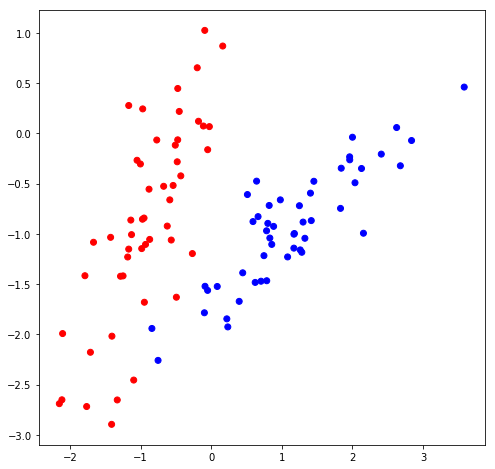

In [12]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [13]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [25]:
regressor = DecisionTreeRegressor().fit(train_data, train_labels, min_leaf=5, max_nodes=100, criteria='enthropy')
preds = regressor.predict(test_data)
test_accuracy = accuracy_metric(test_labels, preds)
print('Точность на тестовой выборке: \t{:5.10f}\n'.format(test_accuracy))

Точность на тестовой выборке: 	73.3333333333



In [24]:
regressor = DecisionTreeRegressor().fit(train_data, train_labels, min_leaf=5, max_nodes=100, criteria='gini')
preds = regressor.predict(test_data)
test_accuracy = accuracy_metric(test_labels, preds)
print('Точность на тестовой выборке: \t{:5.10f}\n'.format(test_accuracy))

Точность на тестовой выборке: 	40.0000000000



### Критерий энтропии дает более точные значения

## 3*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.